##  Notebook 1 of 4
# Machine Learning Based Unbalance Detection of a Rotating Shaft Using Vibration Data
### Oliver Mey, Willi Neudeck, André Schneider and Olaf Enge-Rosenblatt
##### Fraunhofer IIS/EAS, Fraunhofer Institute for Integrated Circuits, Division Engineering of Adaptive Systems, Dresden, Germany

This Jupyter Notebook is part of a paper submission to the 25th IEEE International Conference on Emerging Technologies and Factory Automation, ETFA 2020. The notebook is the first one in a series of four freely available notebooks. It contains Python code fragments which were used to get the classifications results described within the ETFA paper. 

In [58]:
import pandas as pd
import numpy as np
import tensorflow as tf
import scipy as sc
import zipfile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

## Reading Measurement Data

The entire dataset is freely available via the Fraunhofer Fortadis data space (https://fordatis.fraunhofer.de/handle/fordatis/151.2). Anyone who is interested can checkout this data set and can carry out all the calculations described in the publication for themselves. Since the size of the entire dataset is about 2.7 GB, this notebook offers two options: a) A small subset can be used for a first trial. The ZIP file is part of this Github repository. b) The entire dataset is available via the URL as described below. In total, datasets for 4 different unbalance strengths were recorded (1D/1E ... 4D/4E) as well as one dataset with the unbalance holder without additional weight (i.e. without unbalance, 0D/0E). Each dataset is provided as a csv-file with five columns.

In [13]:
# Option a) local file contains a small subset of the entire dataset
url = '../data/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

# Option b) the entire dataset can be directly downloaded via public Fraunhofer Fortadis dataspace
#url = 'https://fordatis.fraunhofer.de/bitstream/fordatis/151.2/1/fraunhofer_eas_dataset_for_unbalance_detection_v1.zip'

In [14]:
with zipfile.ZipFile(url, 'r') as f:
    with f.open('0D.csv', 'r') as c:
        data0D = pd.read_csv(c)
    with f.open('0E.csv', 'r') as c:
        data0E = pd.read_csv(c)
    with f.open('1D.csv', 'r') as c:
        data1D = pd.read_csv(c)
    with f.open('1E.csv', 'r') as c:
        data1E = pd.read_csv(c)
    with f.open('2D.csv', 'r') as c:
        data2D = pd.read_csv(c)
    with f.open('2E.csv', 'r') as c:
        data2E = pd.read_csv(c)
    with f.open('3D.csv', 'r') as c:
        data3D = pd.read_csv(c)
    with f.open('3E.csv', 'r') as c:
        data3E = pd.read_csv(c)
    with f.open('4D.csv', 'r') as c:
        data4D = pd.read_csv(c)
    with f.open('4E.csv', 'r') as c:
        data4E = pd.read_csv(c)

## Skip Warm-up Phase of each Measurement

Each file contains a measured time series of samples (rotation speed, vibrations). Since the first about 10 seconds are noisy due to the warm-up phase of the measuring device, the first 50000 samples are skipped.   

In [24]:
skip = 50000

In [46]:
data0D = data0D.iloc[skip:,:]
data1D = data0D.iloc[skip:,:]
data2D = data0D.iloc[skip:,:]
data3D = data0D.iloc[skip:,:]
data4D = data0D.iloc[skip:,:]

In [47]:
data0E = data0E.iloc[skip:,:]
data1E = data0E.iloc[skip:,:]
data2E = data0E.iloc[skip:,:]
data3E = data0E.iloc[skip:,:]
data4E = data4E.iloc[skip:,:]

## Inspect Datasets 0E and 4E

The following sections show the internal structure of the dataset: The first column contains the input voltage (in V) to the motor controller, the second column contains the measured speed of rotation (in RPM). Columns 3 to 5 contain the signals from the three vibration sensors.

In [28]:
data0E

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
50000,4.0,1026.9841,0.020367,0.033482,0.026215
50001,4.0,1026.9841,0.019192,0.034207,0.026509
50002,4.0,1026.9841,0.016861,0.033402,0.026835
50003,4.0,1026.9841,0.017999,0.033278,0.026187
50004,4.0,1026.9841,0.019349,0.034159,0.025806
...,...,...,...,...,...
6893562,8.1,1959.3277,0.000098,0.000602,0.003182
6893563,8.1,1959.3277,0.000110,0.000299,0.004029
6893564,8.1,1959.3277,0.000626,0.000457,0.003378
6893565,8.1,1959.3277,0.001309,0.000594,0.003142


In [29]:
data0E.describe()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,6.843567e+06,6.843567e+06,6.843567e+06,6.843567e+06,6.843567e+06
mean,6.061296e+00,1.490888e+03,5.884835e-04,7.014949e-04,3.261529e-03
std,1.205810e+00,2.565084e+02,6.512743e-03,8.192315e-03,2.597875e-03
min,4.000000e+00,1.025974e+03,-8.161068e-02,-1.398516e-01,-2.267003e-02
25%,5.000000e+00,1.273534e+03,-1.417399e-03,-1.353025e-03,2.033710e-03
50%,6.100000e+00,1.486869e+03,5.376339e-04,6.043911e-04,3.211498e-03
75%,7.100000e+00,1.710401e+03,2.691746e-03,2.683401e-03,4.520416e-03
max,8.100000e+00,1.959616e+03,8.706570e-02,1.345038e-01,2.895355e-02


In [30]:
data4E

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
50000,4.0,1027.8549,0.011660,0.022202,0.018487
50001,4.0,1027.8549,0.023532,-0.014404,0.016562
50002,4.0,1027.8549,-0.000423,0.049901,0.017732
50003,4.0,1027.8549,-0.000499,0.057977,0.019388
50004,4.0,1027.8549,0.024875,0.009763,0.015419
...,...,...,...,...,...
6914042,4.0,1080.4582,0.002939,-0.003955,0.002704
6914043,4.0,1080.4582,-0.000345,0.002913,0.000757
6914044,4.0,1080.4582,-0.003408,0.002537,-0.001725
6914045,4.0,1080.4582,-0.004315,-0.002156,-0.000253


In [31]:
data4E.describe()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3
count,6.864047e+06,6.864047e+06,6.864047e+06,6.864047e+06,6.864047e+06
mean,6.055147e+00,1.492996e+03,6.847208e-04,6.238618e-04,2.814346e-03
std,1.209247e+00,2.578084e+02,1.476320e-02,1.838645e-02,7.703137e-03
min,4.000000e+00,1.027846e+03,-1.012993e-01,-2.115834e-01,-3.185988e-02
25%,5.000000e+00,1.271982e+03,-6.102323e-03,-6.538629e-03,-1.285076e-03
50%,6.100000e+00,1.487173e+03,5.400181e-04,5.018711e-04,2.655983e-03
75%,7.100000e+00,1.713392e+03,7.725954e-03,7.796287e-03,7.050037e-03
max,8.100000e+00,1.963769e+03,1.093101e-01,1.752233e-01,3.780127e-02


## Plot Measurement Datasets 0E and 4E

The timeseries were divided into windows, each corresponding to one second or 4096 values. The following diagrams show two measurements (timeseries): a) no unbalance, b) largest unbalance. 

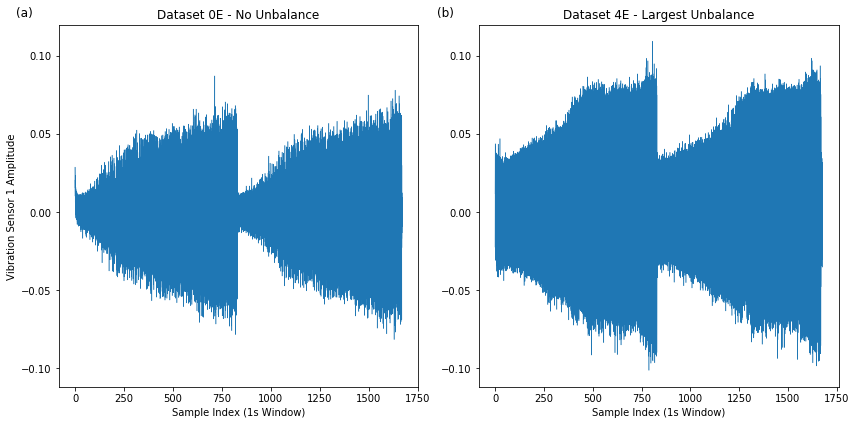

In [45]:
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2, title="Dataset 0E - No Unbalance")
ax1.plot(np.arange(len(data0E['Vibration_1']))/4096, data0E['Vibration_1'], lw=0.5)
ax1.set_xlabel("Sample Index (1s Window)")
ax1.set_ylabel("Vibration Sensor 1 Amplitude")
ax1.text(-300, 0.125,"(a)", fontsize=12)
ax2 = plt.subplot2grid((2, 4), (0, 2), colspan=2, rowspan=2, title="Dataset 4E - Largest Unbalance", sharey=ax1)
ax2.plot(np.arange(len(data4E['Vibration_1']))/4096, data4E['Vibration_1'], lw=0.5)
ax2.set_xlabel("Sample Index (1s Window)")
ax2.text(-300, 0.125,"(b)", fontsize=12)
plt.tight_layout()
fig.savefig("../figures/Fig.4_ab.png", dpi=200)
plt.show()

## Preprocess Data Using FFT

For some classification approaches (e.g. Approch 2 as described in the paper) certain preprocessing and feature extraction steps like Fast Fourier Transformation (FFT) are necessary. The following diagrams show the timeseries as well as the FFT-transformed signals for a range of different rotation speeds.

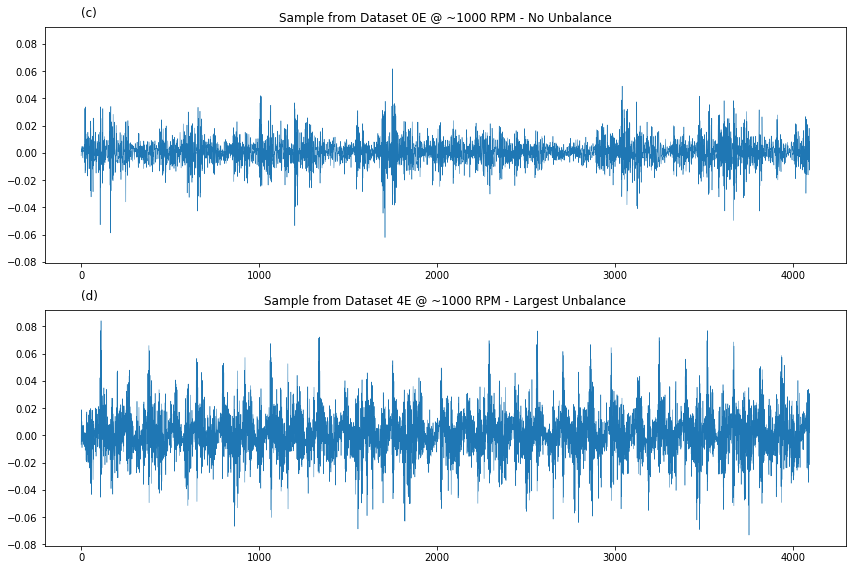

In [55]:
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4, title="Sample from Dataset 0E @ ~1000 RPM - No Unbalance")
ax1.plot(np.arange(4096), data0E['Vibration_1'].loc[2950000:2950000+4095], lw=0.5)
ax1.text(0, 0.1,"(c)", fontsize=12)
ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=4, title="Sample from Dataset 4E @ ~1000 RPM - Largest Unbalance",
                        sharex=ax1, sharey=ax1)
ax2.plot(np.arange(4096), data4E['Vibration_1'].loc[2950000:2950000+4095], lw=0.5)
ax2.text(0, 0.1,"(d)", fontsize=12)
plt.tight_layout()
fig.savefig("../figures/Fig.4_cd.png", dpi=200)
plt.show()

In [56]:
window = 4096

n = int(np.floor(len(data0E['Vibration_1'])/window))
X_0E = data0E['Vibration_1'][:int(n)*window].values.reshape((n, window))
n = int(np.floor(len(data4E['Vibration_1'])/window))
X_4E = data4E['Vibration_1'][:int(n)*window].values.reshape((n, window))

X_0E_fft = np.abs(np.fft.rfft(X_0E, axis=1))[:,:int(window/2)]
X_4E_fft = np.abs(np.fft.rfft(X_4E, axis=1))[:,:int(window/2)]
X_0E_fft[:,0]=0
X_4E_fft[:,0]=0

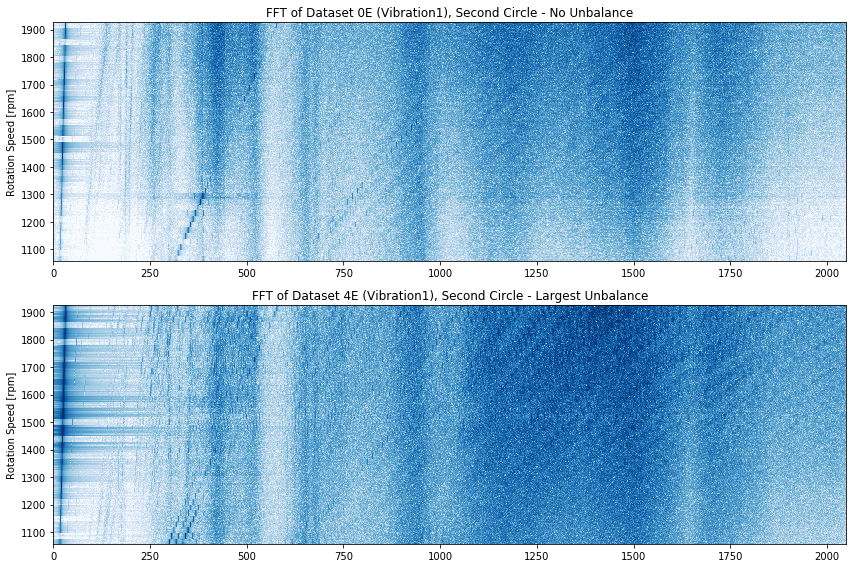

In [59]:
fig = plt.figure(figsize=(12,8))
ax1 = plt.subplot2grid((2, 4), (0, 0), colspan=4, title="FFT of Dataset 0E (Vibration1), Second Circle - No Unbalance")
ax1.pcolorfast(np.arange(1,2050), np.linspace(1057.,1926.2,len(X_0E_fft[831:1670,:])), X_0E_fft[831:1670,:],
           cmap="Blues",norm=LogNorm(vmin=0.005, vmax=5.0))
ax1.set_ylabel("Rotation Speed [rpm]")
ax2 = plt.subplot2grid((2, 4), (1, 0), colspan=4, title="FFT of Dataset 4E (Vibration1), Second Circle - Largest Unbalance")
ax2.pcolorfast(np.arange(1,2050), np.linspace(1057.,1926.2,len(X_4E_fft[831:1670,:])), X_4E_fft[831:1670,:],
           cmap="Blues",norm=LogNorm(vmin=0.005, vmax=5.0))
ax2.set_ylabel("Rotation Speed [rpm]")
plt.tight_layout()
fig.savefig("../figures/Fig.4_ef.png", dpi=200)
plt.show()

## Four Machine Learning Based Approaches for Unbalance Detection

The following four Jupyter Notebooks describe different algorithms for detecting unbalances.

- Approach 1: Convolutional Neural Network on Raw Sensor Data
- Approach 2: Fully-Connected Neural Network on FFT-transformed Data
- Approach 3: Random Forest on Automatically Extracted Timeseries Features
- Approach 4: Hidden Markov Model